# Predicting Music Popularity with tree-based models

# Introduction
How well can we predict the popularity of a song on Spotify using machine learning models?

There is a considerable amount of literature on predicting music popularity using audio features, and many of them apply classification models to determine whether a song is within a certain "bucket" of popularity (top 50 in the charts, popular vs. non-popular). Some papers have demonstrated that tree-based models perform well for classifying songs by popularity.

# Overview

In this assignment, we will practice building a machine learning system with the following guided tasks:

1) **Task 1**: Conduct exploratory data analysis and select representative features

2) **Task 2**: Implement and fine-tune a decision tree classifier, visualize and interprete the model to understand the relationship between the audio features and music popularity

3) **Task 3**: Implement a random forest classifier and compare it with a decision tree classifier to understand the pros and cons of each model

4) **Task 4**: Implement a decision tree regressor and compare it with the decision tree classifier to understand the differences between classification and regression models

5) **Optional task**: Explore how does different data preprocessing steps affect the performance of the decision tree classifier explored in Task2


# Data

This [Spotify](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset) dataset contains over a range of 125 different genres. Each song/track is represented by 20 features (include meta data and audio features) and an indicator of popularity.

In [1]:
# important machine learning and visualization libraries
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [9]:
df_data = pd.read_csv('/content/drive/MyDrive/Assignment/tracks.csv', index_col="sample_id")

# The dataset has 114,000 samples and 21 columns.
df_data.shape

(114000, 20)

In [10]:
# first 5 rows of the dataframe
df_data.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
sample_id,,,,,,,,,,,,,,,,,,,,
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [11]:
# Print the feature variables
print(df_data.columns)

Index(['track_id', 'artists', 'album_name', 'track_name', 'popularity',
       'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')


Check **missing** values and deal with missing values if necessary (refer to A1_EDA).

In [12]:
# check missing values in the dataset

df_data.isnull().sum()

,0
track_id,0
artists,1
album_name,1
track_name,1
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0
key,0


One missing value for each of the three columns: `artists`, `album_name`, `track_name`. You can either remove samples that contain missing values, or ignore the missing values for now.

In [13]:
df_data.dropna(inplace=True)

## Explore target variable
- Target variable: `popularity`

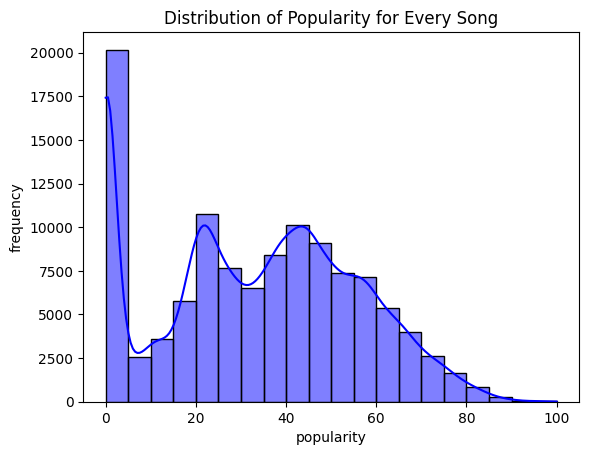

In [14]:
# check the distribution of "popularity"

sns.histplot(df_data['popularity'], kde=True, bins=20, color="blue")
plt.xlabel("popularity")
plt.ylabel("frequency")
plt.title("Distribution of Popularity for Every Song")
plt.show()

In [15]:
# check the number of tracks where "popularity" is 0

(df_data['popularity'] == 0).sum()

np.int64(16019)

In [16]:
# drop all samples whose "popularity" is 0

df_data = df_data[df_data['popularity'] != 0]
df_data.shape

(97980, 20)

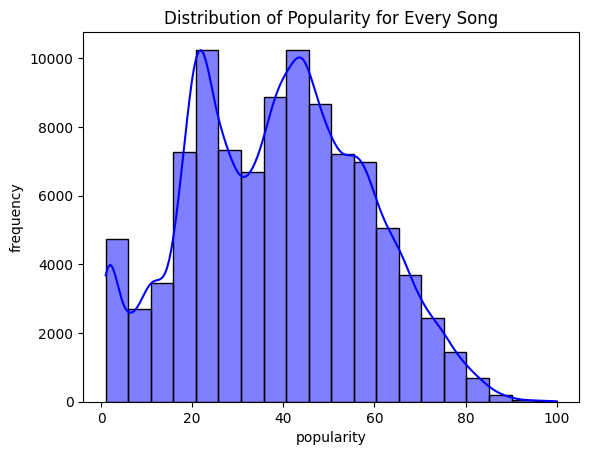

In [17]:
# plot the distribution of "popularity" from the new sample

sns.histplot(df_data['popularity'], kde=True, bins=20, color="blue")
plt.xlabel("popularity")
plt.ylabel("frequency")
plt.title("Distribution of Popularity for Every Song")
plt.show()

### Binarize the target variable
- Calculate the average popularity and find a threshold to binarize the popularity for each sample

In [18]:
avg = df_data['popularity'].mean()
df_data['popularity_label'] = df_data['popularity'].apply(lambda x: 1 if x>= avg else 0)

<Axes: title={'center': 'Popularity distribution'}, xlabel='popularity_label'>

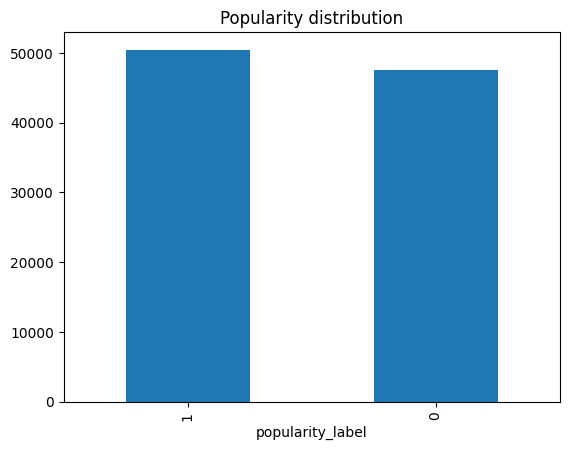

In [19]:
df_data['popularity_label'].value_counts().plot(kind='bar', title="Popularity distribution")

The dataset is almost **equally distributed (balanced)**, which is great for building a ML model.

## Explore feature variables

We select 14 features (10 numerical and 4 categorical) from the original dataset to construct a new dataframe for exploration in this task. We will process each type of feature separately.

In [20]:
# cat_features: categorical features; num_features: numerical features
cat_features = ['popular_genre', 'explicit', 'mode', 'time_signature']
num_features = ['duration_min', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo']

### Categorical feature processing

In terms of music popularity, the genre of the song/track is a strong predictive factor. In this step, we will first create an additional categorical feature, **popular_genre**, to indicate whether the genre of a song is popular, and replace the original categorical feature "track_genre".

In [21]:
# Calculate the average popularity of the tracks by genre

genre_popularity = []
uniq_genres = df_data['track_genre'].unique()
for genre in uniq_genres:
    m = df_data[df_data["track_genre"] == genre]["popularity"].mean()
    genre_popularity.append((genre, round(m,1)))
df_genre = pd.DataFrame(genre_popularity, columns=['genre', 'mean_popularity'])
df_sorted = df_genre.sort_values(by='mean_popularity', ascending = False)
df_sorted.head(20)

,genre,mean_popularity
80,pop-film,59.4
65,k-pop,59.2
81,pop,58.2
31,electro,57.9
53,house,57.2
15,chill,55.9
71,metal,55.0
30,edm,54.9
56,indie-pop,54.9
57,indie,54.5


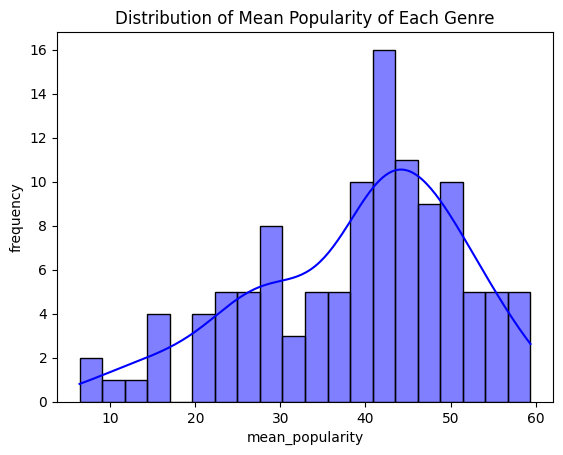

In [22]:
# show the distribution of mean popularity by genre

sns.histplot(df_sorted['mean_popularity'], kde=True, bins=20, color="blue")
plt.xlabel("mean_popularity")
plt.ylabel("frequency")
plt.title("Distribution of Mean Popularity of Each Genre")
plt.show()

Based on this histogram plot, we will **use 30 as the threshold** to determine whether the genre of a track/song is popular or not and create a new binary feature **popular_genre** to replace **track_genre**.

In [23]:
df_data['popular_genre'] = 0
lst_genre = df_sorted[df_sorted['mean_popularity'] >= 30]['genre'].unique()
df_data.loc[df_data['track_genre'].isin(lst_genre), 'popular_genre'] = 1

In [24]:
df_data.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_label,popular_genre
sample_id,,,,,,,,,,,,,,,,,,,,,
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,1,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,1,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,1,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,1,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,1,1


### Categorical feature processing

We will first check the **distribution** of each categorical feature and then **encode** each feature separately.

**popular_genre**

In [25]:
df_data['popular_genre'].value_counts()

,count
popular_genre,
1,72967
0,25013


**explicit**

In [26]:
df_data['explicit'].value_counts()

,count
explicit,
False,89538
True,8442


**mode**

In [27]:
df_data['mode'].value_counts()

,count
mode,
1,62169
0,35811


**time_signature**

In [28]:
df_data['time_signature'].value_counts()

,count
time_signature,
4,87886
3,7560
5,1530
1,845
0,159


In [29]:
# convert "time_signature" into a binary variable based on whether the track is in 4/4

df_data['time_signature'] = df_data['time_signature'].apply(lambda x: 1 if x == 4 else 0)

- According to the distribution of each categorical feature, we will apply OneHotEncoder for each feature.
- Later on, we will have an additional discussion about **whether it is necessary** to encode categorical features and if we don't encode categorical features, how will this affect model performance.

In [30]:
df_data.time_signature.value_counts()

,count
time_signature,
1,87886
0,10094


In [31]:
df_data[cat_features].head()

,popular_genre,explicit,mode,time_signature
sample_id,,,,
0,1,False,0,1
1,1,False,1,1
2,1,False,1,1
3,1,False,1,0
4,1,False,1,1


Apply **OneHotEncoding** for each categorical variable

In [32]:
# Initiate a one-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')
df_cat = df_data[cat_features]
ohe.fit(df_cat)

# # encode the features with the fitted encoder
df_cat_ohe = pd.DataFrame(ohe.transform(df_cat).toarray())

# rename columns to make it expressive
col_names = []
for i in range(len(cat_features)):
    for j in ohe.categories_[i]:
        col_names.append(cat_features[i] + '_' + str(j))

names_dict = {i:col_names[i] for i in range(len(col_names))}
df_cat_ohe.rename(columns=names_dict, inplace=True)
df_cat_ohe.index = df_data.index # add an index column to keep track of each sample

In [33]:
df_cat_ohe.head()

,popular_genre_0,popular_genre_1,explicit_False,explicit_True,mode_0,mode_1,time_signature_0,time_signature_1
sample_id,,,,,,,,
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


### Numerical feature processing

Check the data distribution and outliers of each numerical variable.

In [34]:
# Create a function for this part to organize the code
def clean_numerical(df, col):
    '''takes a dataset df and a column name col as input'''

    # draw boxplot of the column
    plt.figure(figsize=(6, 4));
    sns.boxplot(x=df[col])
    plt.title("Boxplot of %s for Every Song" % col)
    plt.show();
    plt.clf()

    print(df.shape)
    # remove outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # visualize the histogram of the cleaned data
    sns.histplot(df[col], kde=True, bins=20, color="blue")
    plt.title("Distribution of %s after remove outliers" % col)
    plt.show();
    plt.clf()

    # scale the feature
    scaler = MinMaxScaler()
    df.loc[:, col] = scaler.fit_transform(df[[col]])
    print("Successfully scaled the feature: %s" % col)

    return df

**duration_min**

In [35]:
# change the unit for duration into minute and rename the column

df_data['duration_ms'] = df_data['duration_ms'] * 1000 / 60
df_data.rename(columns={'duration_ms': 'duration_min'}, inplace=True)

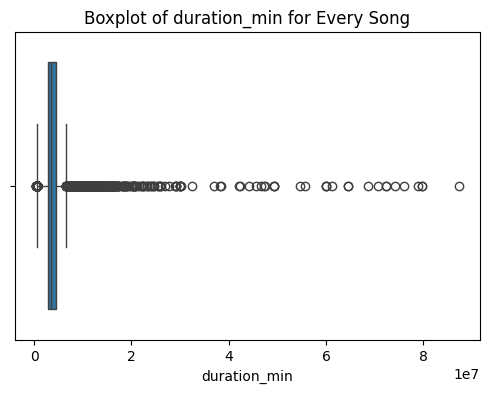

(97980, 22)


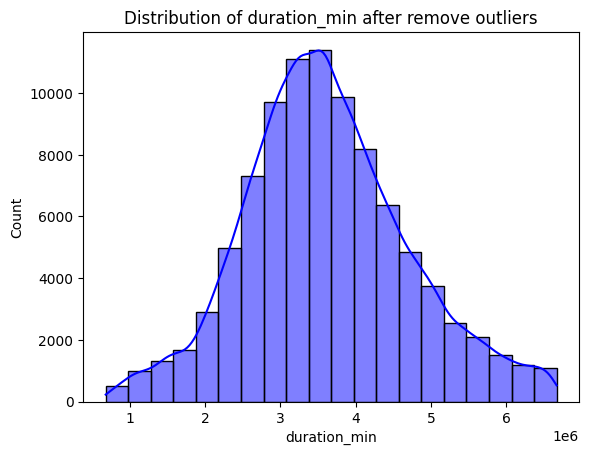

Successfully scaled the feature: duration_min


<Figure size 640x480 with 0 Axes>

In [36]:
df_data = clean_numerical(df_data, col='duration_min')

**danceability**

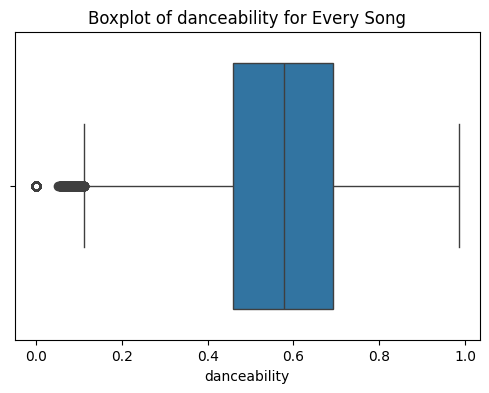

(93353, 22)


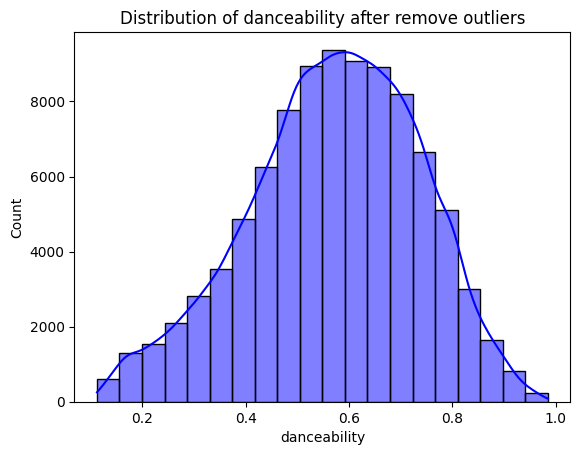

Successfully scaled the feature: danceability


<Figure size 640x480 with 0 Axes>

In [37]:
df_data = clean_numerical(df_data, col='danceability')

**energy**

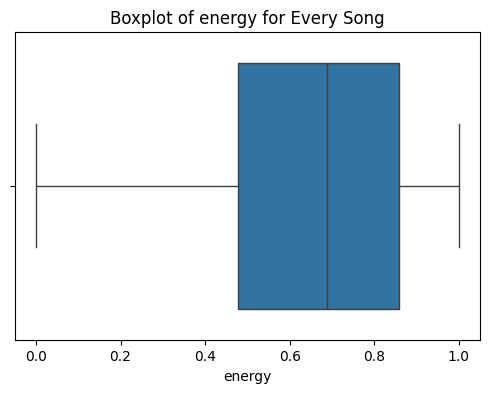

(92771, 22)


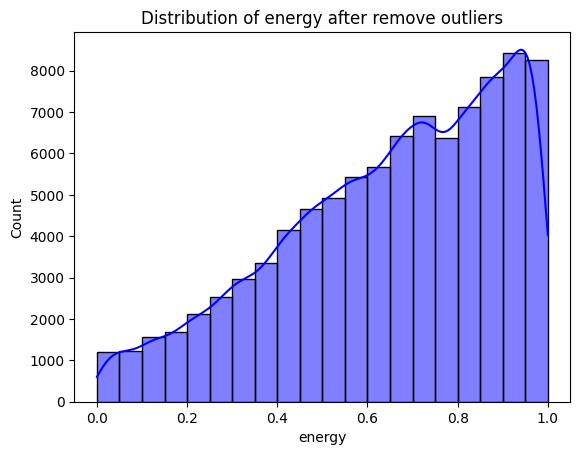

Successfully scaled the feature: energy


<Figure size 640x480 with 0 Axes>

In [38]:
df_data = clean_numerical(df_data, col='energy')

**loudness**

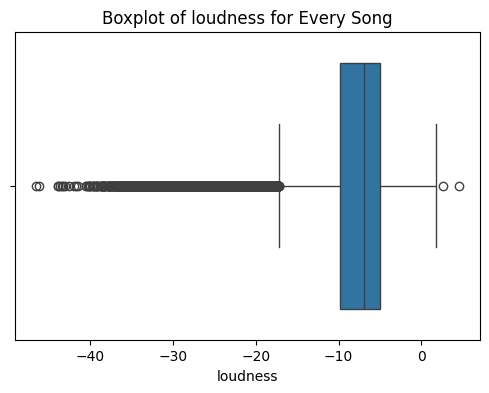

(92771, 22)


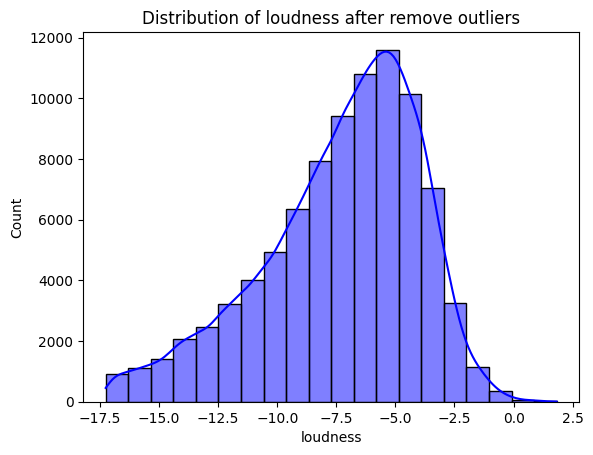

Successfully scaled the feature: loudness


<Figure size 640x480 with 0 Axes>

In [39]:
df_data = clean_numerical(df_data, col='loudness');

**speechiness**

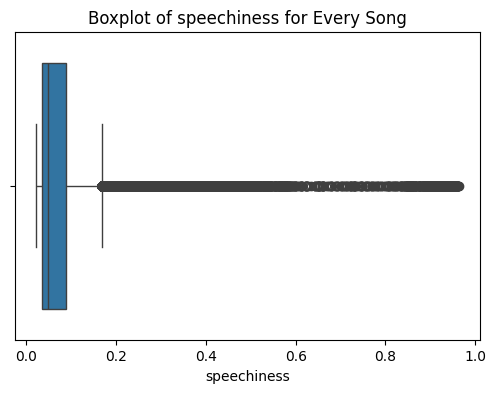

(88228, 22)


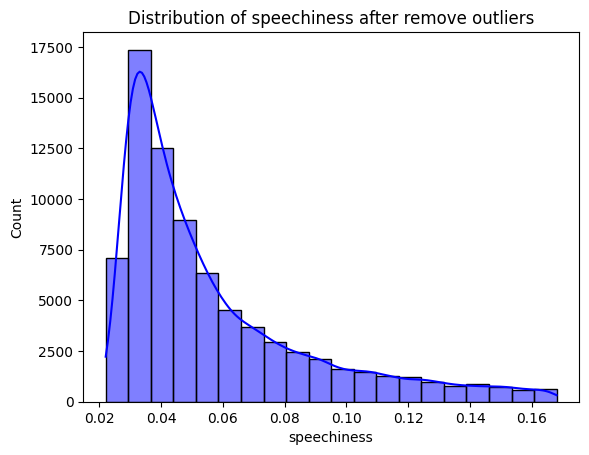

Successfully scaled the feature: speechiness


<Figure size 640x480 with 0 Axes>

In [40]:
df_data = clean_numerical(df_data, col='speechiness');

**acousticness**

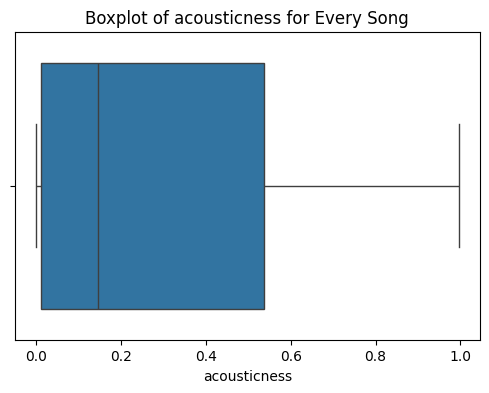

(78138, 22)


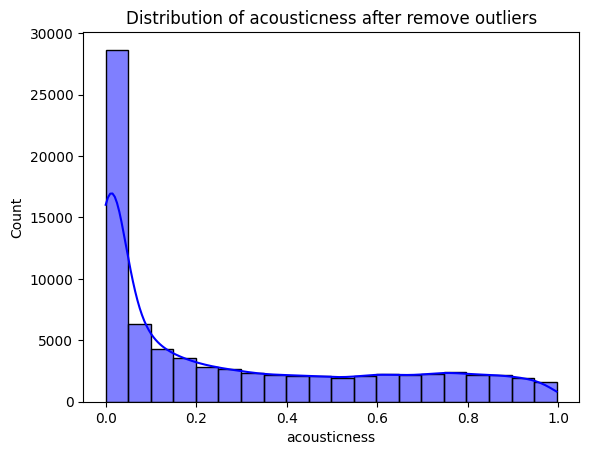

Successfully scaled the feature: acousticness


<Figure size 640x480 with 0 Axes>

In [41]:
df_data = clean_numerical(df_data, col='acousticness');

**instrumentalness**

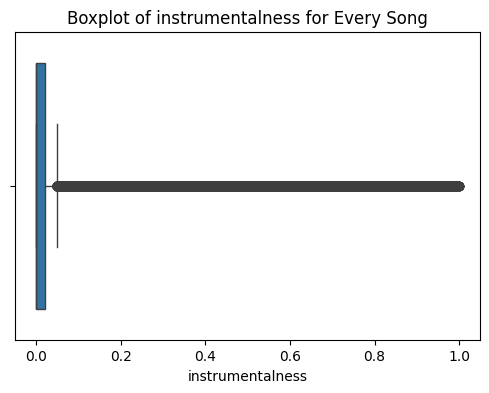

(78138, 22)


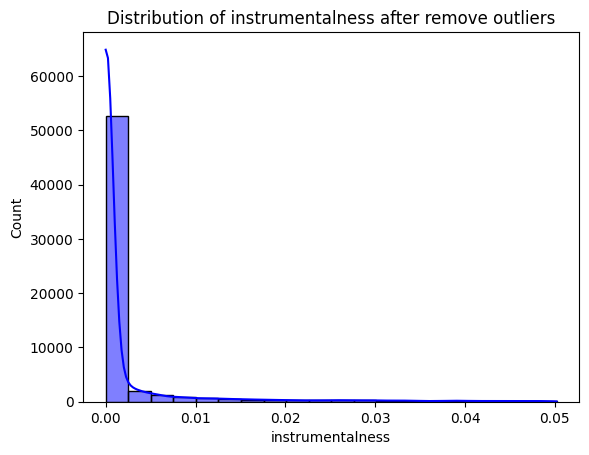

Successfully scaled the feature: instrumentalness


<Figure size 640x480 with 0 Axes>

In [42]:
df_data = clean_numerical(df_data, col='instrumentalness')

**liveness**

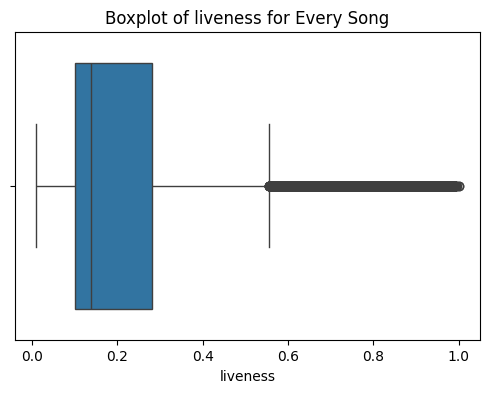

(60869, 22)


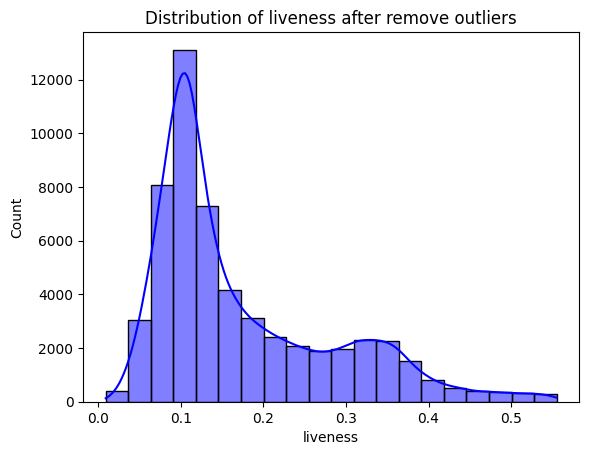

Successfully scaled the feature: liveness


<Figure size 640x480 with 0 Axes>

In [43]:
df_data = clean_numerical(df_data, col='liveness')

**valence**

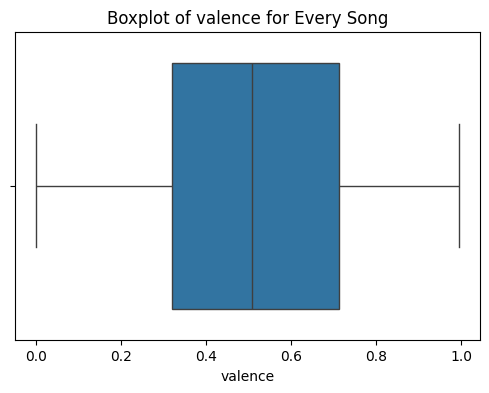

(56406, 22)


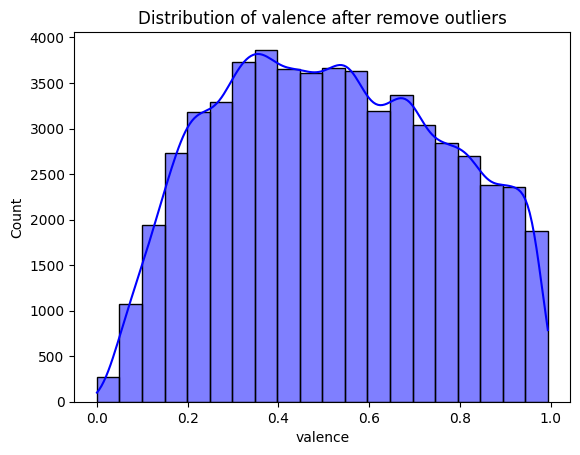

Successfully scaled the feature: valence


<Figure size 640x480 with 0 Axes>

In [44]:
df_data = clean_numerical(df_data, col='valence')

**tempo**

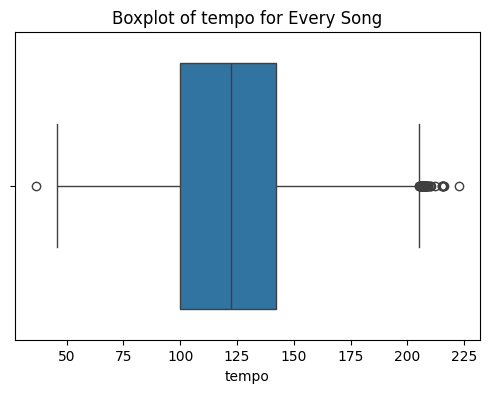

(56406, 22)


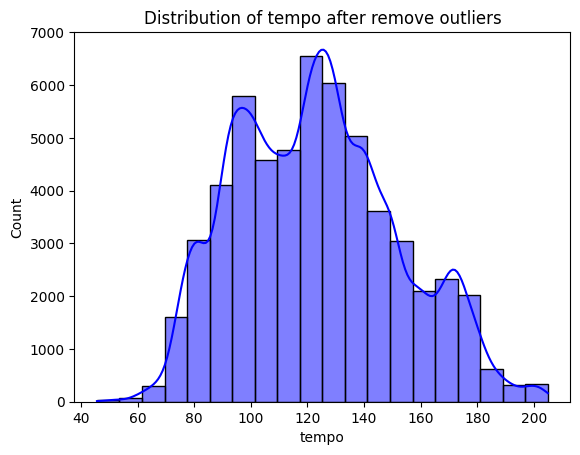

Successfully scaled the feature: tempo


<Figure size 640x480 with 0 Axes>

In [45]:
df_data = clean_numerical(df_data, col='tempo')

#### **Task 1.1: Feature Discussion**

We now have a large number of box and whisker plots and histograms showing us the within-group distributions of our features. You can never be too familiar with your data, so before moving any further let's pause a second to observe the distributions.


> __Your Task__: Take a moment and look at the above plots. What differences do you observe between the distributions of our variables? Do any seem have particularly nice (e.g. normal) distributions? Do any seem particularly skewed? Make two to three observations. Hypothesizing, are there any features which you believe will be highly predictive of whether a song is popular or not?

>_NB: Generally speaking, we do not expect any long text responses in this assignment to take more than a paragraph. In fact, some prompts can likely be addressed in a sentence or two, so just use however much (or little!) room you need to fully address the prompt._


(Your answer, here)

- Many features like danceability, duration_min, and loudness show relatively symmetric, normal-like distributions after outliers are removed, which suggests good data quality for modeling.
- In contrast, features like instrumentalness and acousticness are highly left-skewed, indicating that most songs have low values for those.
- I hypothesize that features such as energy, danceability, and loudness may be predictive of song popularity, as they relate to how engaging a song might feel.

**Check feature colinearty**

After processing the features and investigating their distributions, we now plot a heatmap to investigate the correlation between every two features.

***Note from the TA***: *correlation heatmaps like that below can be really useful in your own work, so take note of how this was made!*

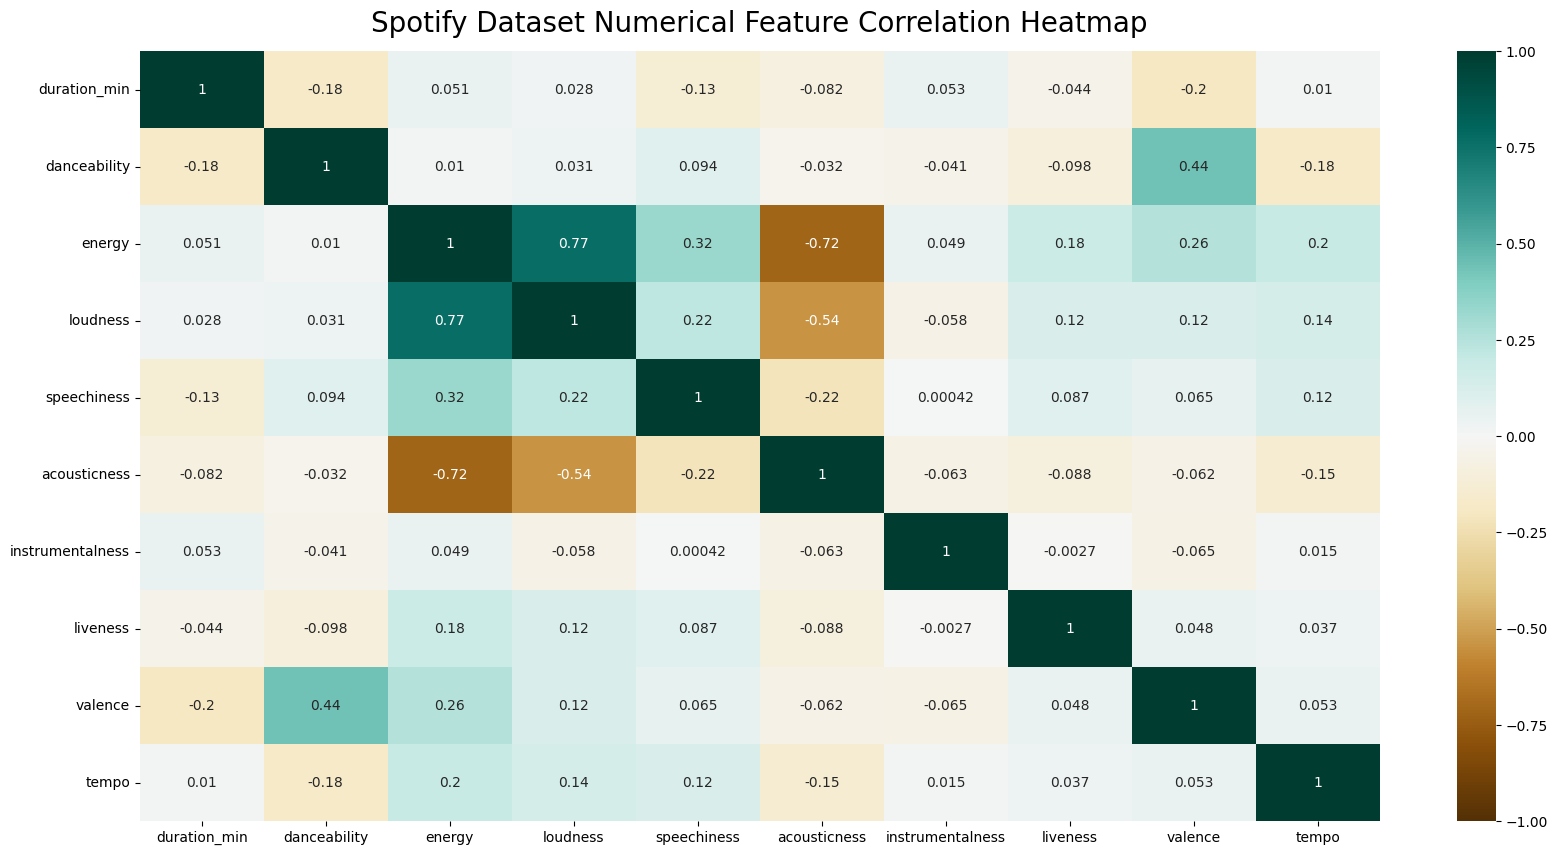

In [46]:
# set the size of the heatmap.
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df_data[num_features].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Set the title
heatmap.set_title('Spotify Dataset Numerical Feature Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

#### **Task 1.2: Feature Trimming**

If we identify a pair of highly correlated features (i.e. features with $\vert \text{correlation}\vert \geq 0.7$), we will only keep one and remove the others.

> __Your Task__: Use the above correlation plot to identify highly correlated pairs of features. Define a list `new_num_features` which is just `num_features` but without highly correlated features. Then, explain why we want to remove highly correlated features. What problems can these pose for our models?

In [47]:
# we create a new list of numerical features by removing 'energy'
new_num_features = ['duration_min', 'danceability', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo']

## Finalize the feature matrix
- We now construct the final data matrix from the processed numerical and categorical features
- We then split the data matrix into training and testing to prepare for model training

In [48]:
X_data = pd.merge(df_data[new_num_features], df_cat_ohe, left_index=True, right_index=True, how='inner')

feature_names = X_data.columns.to_list()
X_data.shape

(56332, 17)

In [49]:
# Create target variable
y_data = df_data[['popularity_label']]
y_data.shape

(56332, 1)

In [50]:
# Split the data into training and testing
X_train, X_test, y_train, y_test  = train_test_split(X_data, y_data, test_size = 0.3, random_state = 42)

In [51]:
# Check the shape of training and testing feature matrix
X_train.shape, X_test.shape

((39432, 17), (16900, 17))

In [52]:
# Check the data distributon of the target variable in training and testing set
print("training:", y_train.value_counts(),'\n')
print("testing:", y_test.value_counts())

training: popularity_label
1                   22389
0                   17043
Name: count, dtype: int64 

testing: popularity_label
1                   9714
0                   7186
Name: count, dtype: int64


# Model training and testing

We've now finished exploring our initial dataset and created two mini datasets: a **training** dataset consistng of `X_train` and `y_train`; and a **testing** dataset consisting of `X_test` and `y_test`.

We will use the training set to train our models, and then we will evaluate model performance on the held-out testing data. In this section, you will go through this process for three types of tree-based models:

> 1) Decision Tree Classifier

> 2) Random Forest Classifier

> 3) Decision Tree Regressor



## Task 2: Decision tree classifier

The first of the three models we will explore is the __Decision Tree Classifier__, which uses a series of binary choices to predict the category a given observation belongs to. You can read the documentation for the `sklearn` implementation of the classifier [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

![Simple Decision Tree Classifier, stolen ruthlessly from an Ecosia search](https://ieftimov.com/posts/classifier-decision-trees/index_files/decision-tree-graphic.png)

> __Your Task__: Import the `DecisionTreeClasisfier` class from `sklearn.tree`. Create a classifier named `dt_clf` with a `random_state` of 42. `fit` the classifier on your training data, and then caclulate the `score` of `dt_clf` on the testing data. Interpret the score metric: is the model performing well or poorly?

In [53]:
# Your code here: This should only take around 4 lines of code.
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42)

dt_clf.fit(X_train, y_train)

score = dt_clf.score(X_test, y_test)

In [54]:
print("Test Accuracy:", score)

Test Accuracy: 0.7271597633136094


Now that we've tried the model with it's default parameters, we should explore different hyperparameter settings to improve the model performance.

> __Your Task__: First, explore how the model's results change with different hyperparameter settings. For instance, check how different combinations of values for `criterion`, `max_depth`, `min_samples_split`, and `min_samples_leaf` impact the model's performance. Keep track of the best performing set of hyperparameters for use in the next step.

> Then, briefly discuss what you find and how your findings relate to the pros and cons of decision trees. If you are unable to improve the score through hyperparameyer tuning, try to explain the reason based on what we learned in class.

In [55]:
# Your code here:
dt_depth3 = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_depth3.fit(X_train, y_train)
print(dt_depth3.score(X_test, y_test))

0.7176331360946746


In [56]:
dt_depth5_entropy = DecisionTreeClassifier(max_depth=7, criterion='entropy', random_state=42)
dt_depth5_entropy.fit(X_train, y_train)
print(dt_depth5_entropy.score(X_test, y_test))

0.714792899408284


In [57]:
dt_depth10_split5 = DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=42)
dt_depth10_split5.fit(X_train, y_train)
print(dt_depth10_split5.score(X_test, y_test))

0.7176923076923077


In [58]:
dt_full_leaf4 = DecisionTreeClassifier(max_depth=None, min_samples_leaf=4, random_state=42)
dt_full_leaf4.fit(X_train, y_train)
print(dt_full_leaf4.score(X_test, y_test))

0.7028402366863905


### Findings：
- Through testing different hyperparameter settings on the decision tree model, it was found that the default parameters performed best on this dataset, achieving an accuracy of 72.7%. When limiting the depth of the tree (e.g., `max_depth=4`), the accuracy decreased, likely due to the model being too simple and underfitting the data. Other constraints such as `min_samples_split` and `min_samples_leaf` also reduced the model's flexibility and led to slightly lower performance.
- These results demonstrate that hyperparameters like `max_depth` and `min_samples_leaf` directly control the model's learning capacity. If the model is allowed too much freedom, it may overfit; if restricted too much, it may underfit. In this particular dataset, the unrestricted default settings offered a good balance. However, this outcome may vary across different datasets, highlighting the importance of hyperparameter tuning.

One of the primary benefits of decision trees is that they are _inherently interpretable_ models, meaning we have multiple methods to easily understand why the model makes the decisions it does. In the following steps, we'll explore the relationships learned by your best performing decision tree classifier.

> __Your Task__: In the previous step, you explored groups of potential hyperparameters. Create a model with the highest performing set of hyperparameters called `best_dt_clf`. Then, use `graphviz` to visualize the tree. What patterns do you see in the tree? Which features are split on early, and which are split on later?

In [59]:
# Your code here
best_dt_clf = DecisionTreeClassifier(random_state=42)
best_dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [60]:
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

In [61]:
from sklearn.tree import export_graphviz
from graphviz import Source

dot_data = export_graphviz(
    best_dt_clf,
    out_file=None,
    feature_names=feature_names,
    class_names=['Not Popular', 'Popular'],
    filled=True,
    rounded=True,
    special_characters=True
)

Source(dot_data)

Output hidden; open in https://colab.research.google.com to view.

As discussed in class, decision trees split on features with the goal of making the largest reduction in a criterion function, such as entropy. This also means that decision trees have a natural concept of feature importance: the importance of a given feature is the sum of the reduction in uncertainty/impurity for each node on which the feature is split.

> __Your Task__: Extract the `feature_importances_` from `best_dt_clf`, and create a DataFrame showing each feature and its importance. Sort the results in descending order of importance, and print the result.

> Your result table should look like the below table, but with many more rows (and potentially different values, make sure to round all values to 2 digits).

>features | importances
>----------|-------------
>popular_genre_1    |0.14
>tempo|0.1
>valence       | 0.1

> After making your table, answer the discussion questions below.



In [63]:
# Your Code Here
importances = best_dt_clf.feature_importances_

feat_imp_df = pd.DataFrame({'features': feature_names,'importances': importances})

feat_imp_df = feat_imp_df.sort_values(by='importances', ascending=False)
feat_imp_df['importances'] = feat_imp_df['importances'].round(2)

print(feat_imp_df)

            features  importances
10   popular_genre_1         0.18
4       acousticness         0.11
7            valence         0.10
0       duration_min         0.09
1       danceability         0.09
8              tempo         0.09
3        speechiness         0.09
2           loudness         0.09
6           liveness         0.08
5   instrumentalness         0.05
14            mode_1         0.01
13            mode_0         0.00
16  time_signature_1         0.00
11    explicit_False         0.00
12     explicit_True         0.00
15  time_signature_0         0.00
9    popular_genre_0         0.00


**Discussion Q1. What can we take away from the above results? What features explain the most variations? Can you explain whether the top features make sense in terms of the context of music?**


(Your answer here)

- From the feature importance rankings, popular_genre_1, acousticness, valence, and duration_min stand out as key predictors of song popularity. These features reflect both musical content and format. Genre captures general audience preferences—songs in mainstream styles like pop or hip-hop are more likely to be recommended and widely played. Acousticness and valence describe the mood and production style of a track; upbeat, electronically produced songs with positive emotions often perform better in social and viral contexts. Duration also plays a role—most popular songs fall within a standard 2–4 minute range, aligning with streaming habits and user attention spans. Overall, these features offer meaningful insight into what makes a song more likely to be popular.

**Discussion Q2. Are these results robust? That is, to what extent can we trust these results to be indicative of true underlying trends in our dataset?**

(Your answer here)

- While the results offer valuable insights, they may not be entirely robust. Since decision trees are sensitive to changes in the training data, small variations or different data splits could lead to slightly different feature importance rankings. Although this dataset is fairly large and balanced, relying on a single tree can still introduce instability. A more reliable estimate of feature importance might come from using ensemble methods like Random Forests, which average results over many trees. Therefore, while these findings are helpful, they should be interpreted as indicative rather than absolute.

## [Optional task] How does feature processing affect the performance of tree-based models?
In the above sections, we conduct the following data processing steps:
- for categorical features, we do one-hot encoding
- for numerical features, we checked the outlier distribution and multicollinearity, and removed highly correlated features.

In this section, you will do some free exploration to see how does the following change affect model performance:
- for categorical features, experiment by **not encoding** categorical features and check how this affects model performance
- for numerical features, experiment by **not removing outliers** for one or more numerical features and check how this affects model performance

In your exploration, write comments along with your code, discuss the results, and provide additional insights (the same style as we provided in this jupyter notebook).

In [64]:
# Your Code Here
X_cat_raw = df_data[['popular_genre']]
X_num = df_data[new_num_features]

X_raw = pd.concat([X_cat_raw, X_num], axis=1)

y_raw = df_data['popularity_label']

In [68]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

In [69]:
dt_raw = DecisionTreeClassifier(random_state=42)

dt_raw.fit(X_train_raw, y_train_raw)
score_raw = dt_raw.score(X_test_raw, y_test_raw)

In [70]:
print(score_raw)

0.7210650887573965


In [71]:
X_num_raw = df_data[num_features]

X_cat = df_data[['popular_genre']]

X_raw2 = pd.concat([X_cat, X_num_raw], axis=1)

y_raw2 = df_data['popularity_label']

In [72]:
X_train_raw2, X_test_raw2, y_train_raw2, y_test_raw2 = train_test_split(X_raw2, y_raw2, test_size=0.3, random_state=42)

In [73]:
dt_raw2 = DecisionTreeClassifier(random_state=42)
dt_raw2.fit(X_train_raw2, y_train_raw2)

score_raw2 = dt_raw2.score(X_test_raw2, y_test_raw2)

In [74]:
print(score_raw2)

0.73


## Task 3: Random Forest Classifier

The second of the three tree-based models we will explore in this notebook is the __Random Forest Classifier__, which tallies votes from a forest of Decision Tree Classifiers trained on a subset of the data to come to its conclusions. You can read the documentation for the `sklearn` implementation of the classifier [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

![RF Example Image](https://liorsinai.github.io/assets/posts/random-forests/Random_forest_diagram_complete.png)

> __Your Task__: Import the `RandomForestClassifier` class from `sklearn.ensemble`. Create a classifier named `rf_clf` with a `random_state` of 42. `fit` the classifier on your training data, and then calculate the `score` of `rf_clf` on the testing data. Interpret the score metric: is the model performing poorly or well?




In [75]:
# # Your Code Here: This should also take about 4 lines
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_score = rf_clf.score(X_test, y_test)

In [76]:
print(rf_score)

0.7829585798816568


As with the Decision Tree Classifier, we should explore how different hyperparameter settings impact model performance.

> __Your Task__: First, explore how the model's results change with different hyperparameter settings. For instance, check how different combinations of values for `criterion`, `n_estimators`, `max_features`, `max_depth`, and `min_samples_leaf` impact the model's performance. Keep track of the best performing set of hyperparameters for use in the next step, and keep `random_state=42` throughout.

> Use the best set of hyperparameters to train a model called `best_rf_clf`, and report its score metric.

In [77]:
rf1 = RandomForestClassifier(criterion='gini', random_state=42)
rf1.fit(X_train, y_train)
print("gini:", rf1.score(X_test, y_test))

rf2 = RandomForestClassifier(criterion='entropy', random_state=42)
rf2.fit(X_train, y_train)
print("entropy:", rf2.score(X_test, y_test))

gini: 0.7829585798816568
entropy: 0.7843786982248521


In [78]:
rf3 = RandomForestClassifier(n_estimators=50, random_state=42)
rf3.fit(X_train, y_train)
print("n_estimators=50:", rf3.score(X_test, y_test))

rf4 = RandomForestClassifier(n_estimators=200, random_state=42)
rf4.fit(X_train, y_train)
print("n_estimators=200:", rf4.score(X_test, y_test))

n_estimators=50: 0.7803550295857988
n_estimators=200: 0.7823076923076923


In [79]:
rf5 = RandomForestClassifier(max_features='sqrt', random_state=42)
rf5.fit(X_train, y_train)
print("max_features=sqrt:", rf5.score(X_test, y_test))

rf6 = RandomForestClassifier(max_features='log2', random_state=42)
rf6.fit(X_train, y_train)
print("max_features=log2:", rf6.score(X_test, y_test))

max_features=sqrt: 0.7829585798816568
max_features=log2: 0.7829585798816568


In [80]:
rf7 = RandomForestClassifier(max_depth=10, random_state=42)
rf7.fit(X_train, y_train)
print("max_depth=10:", rf7.score(X_test, y_test))

rf8 = RandomForestClassifier(max_depth=30, random_state=42)
rf8.fit(X_train, y_train)
print("max_depth=30:", rf8.score(X_test, y_test))

max_depth=10: 0.7322485207100592
max_depth=30: 0.7844378698224852


In [81]:
rf9 = RandomForestClassifier(min_samples_leaf=1, random_state=42)
rf9.fit(X_train, y_train)
print("min_samples_leaf=1:", rf9.score(X_test, y_test))

rf10 = RandomForestClassifier(min_samples_leaf=5, random_state=42)
rf10.fit(X_train, y_train)
print("min_samples_leaf=5:", rf10.score(X_test, y_test))

min_samples_leaf=1: 0.7829585798816568
min_samples_leaf=5: 0.7687573964497041


In [82]:
best_rf_clf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=200,
    max_features='sqrt',
    max_depth=30,
    min_samples_leaf=1,
    random_state=42
)

In [83]:
best_rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, n_estimators=200,
                       random_state=42)

In [84]:
best_rf_score = best_rf_clf.score(X_test, y_test)
print(best_rf_score)

0.7846745562130177


While one could visualize random forests, the models tend to have too many trees for a visual analysis to be very informative. However, we can still calculate feature importances in the same way we do for decision trees.

> __Your Task__: Extract the `feature_importances_` from `best_rf_clf`, and create a DataFrame showing each feature and its importance. Sort the results in descending order of importance, and print the result.

> Your result table should look like the below table, albeit with many more rows and potentially different values (round to 2 digits).

>features | importances
>----------|-------------
>duration_min|0.18
>acousticness|0.13
>danceability| 0.10

> After making your table, answer the discussion questions below.

In [86]:
# Your code here
importances = best_rf_clf.feature_importances_

feat_imp_df = pd.DataFrame({'features': feature_names,'importances': importances})

feat_imp_df = feat_imp_df.sort_values(by='importances', ascending=False)
feat_imp_df['importances'] = feat_imp_df['importances'].round(2)

print(feat_imp_df)

            features  importances
7            valence         0.10
4       acousticness         0.10
0       duration_min         0.10
8              tempo         0.10
2           loudness         0.10
1       danceability         0.09
3        speechiness         0.09
6           liveness         0.09
9    popular_genre_0         0.08
10   popular_genre_1         0.06
5   instrumentalness         0.06
13            mode_0         0.01
14            mode_1         0.01
15  time_signature_0         0.00
16  time_signature_1         0.00
11    explicit_False         0.00
12     explicit_True         0.00


**Discussion Q1. Do the important features make sense within the context of music popularity?**

- Yes, the most important features identified—such as valence, acousticness, and duration_min—make intuitive sense in the context of music popularity. Valence measures how positive or upbeat a song is, which often aligns with popular tracks that evoke emotional resonance or are used in social media. Acousticness helps distinguish between acoustic and more electronic songs; electronic tracks tend to perform better in environments like gyms, clubs, or short videos. While duration_min may seem less directly relevant, it reflects industry norms—popular songs often fall within a 2–4 minute range, aligning with streaming and attention-span preferences. These features represent both content style and platform compatibility, which are key factors in determining a song’s popularity.

(Your text here)

**Discussion Q2. Comparing `best_dt_clf` and `best_rf_clf`, which model provides better performance? Why might this be?**

- Based on the accuracy scores, best_rf_clf performs slightly better than best_dt_clf. This is expected, as Random Forest reduces overfitting by averaging multiple decision trees. While a single decision tree is sensitive to noise and specific data splits, the ensemble approach introduces randomness and aggregation, resulting in more stable generalization on unseen data. This makes Random Forest more reliable, especially when the dataset contains many weak predictors.

(Your text here)

**Discussion Q3. Are the important features consistent between `best_dt_clf` and `best_rf_clf`? Highlight the similarities and differences.**

- Overall, both models highlight similar top features—such as valence, acousticness, and duration_min—suggesting these are core indicators of song popularity. However, the exact order of importance differs. For instance, popular_genre_1 ranks highest in the decision tree, but drops slightly in the random forest. This difference likely reflects how decision trees focus on a few dominant splits, while random forests distribute importance more evenly across features. Despite the variation in ranking, the key patterns remain consistent.

(Your text here)

**Discussion Q4. Can conclusions be drawn from the Random Forest Classifier feature importances be considered as more robust than those drawn from the Decision Tree Classifier? Why or why not?**

- Yes, the feature importances from the Random Forest are generally more robust. Unlike a single decision tree, which can produce highly variable results depending on the data split, Random Forest combines many trees trained on different subsets of the data and features. This aggregation reduces the chance of overemphasizing specific splits, making the importance scores more stable and reliable. Therefore, if the goal is to understand overall trends, Random Forest offers a more dependable assessment.

(Your text here)

## Task 4: Decision Tree Regressor

The third model we will explore in this notebook is the Decision Tree Regressor. Unfortunately, this means we need to do a bit more data cleaning: as of now, `y_train` and `y_test` contain categorical features, meaning a decision tree regressor is inappropriate for predicting them. Thus, we start this task by picking and cleaning a new target variable: `popularity`.

> __Your Task__: As a first step towards setting up our training and testing data, we should check the distribution of our outcome variable. Plot a histogram showing the distribution of `popularity`. Does the distribution look fine, or does it warrant further cleaning? Why or why not?

<Axes: >

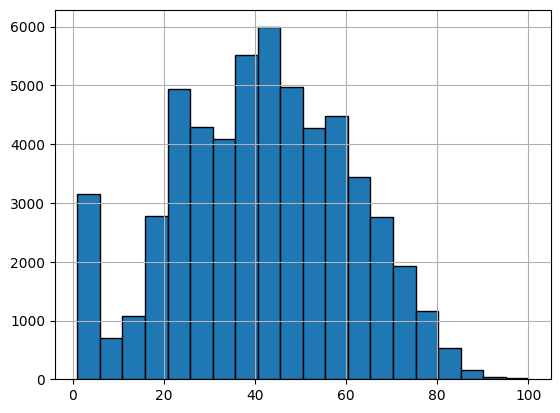

In [87]:
# Your code here
df_data['popularity'].hist(bins=20,edgecolor="black")

Now that we've looked at `popularity` and confirmed that it either looks fine or looks horrible (depending on your above conclusions), we should actually make our training and testing datasets.

> __Your Task__: Create `y_reg`, a copy of the `popularity` column in `X_data`. Additionally, create `X_reg` by dropping `popularity` from `X_data`. Then, use `train_test_split` to create training and testing sets of the data. Use a random state of 42 and use 80% of the data for training. Print the shapes of the training and testing variables.

In [88]:
# Your code here
X_reg = X_data.copy()
y_reg = df_data['popularity']

In [89]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Now that we have our data preprocessed, we can fit a Decision Tree Regressor on the dataset. You can find the documentation for the regressor [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

> __Your Task__: Import the `DecisionTreeRegressor` class from `sklearn.tree`. Create, fit, and score the regression model, exploring different hyperparameters for the model listed on the documentation. Save the best performing model to a variable named `best_dt_reg` and report it's score on the testing dataset. Use a random state of 42 throughout.

In [90]:
# Your code here
from sklearn.tree import DecisionTreeRegressor

In [91]:
reg = DecisionTreeRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)
reg.score(X_test_reg, y_test_reg)

0.09962525423030211

In [92]:
best_dt_reg = reg

Decision Trees are inherently interpretable, so we should attempt to interpret the results.

> __Your Task__: In the previous task, you created a Decision Tree Regressor named `best_dt_reg`. Let's interpret the regressor in two steps.

> First, use `graphviz` to visualize the tree. What patterns do you see in the tree? Which features are split on early, and which are split on later?

> Second, extract the `feature_importances_` from `best_dt_reg`, and create a DataFrame showing each feature and its importance. Sort the results in descending order of importance, and print the result.

> After making your table, answer the discussion questions below.

In [99]:
# Limit tree depth for better visualization and interpretability
reg = DecisionTreeRegressor(random_state=42, max_depth=4)
reg.fit(X_train_reg, y_train_reg)

DecisionTreeRegressor(max_depth=4, random_state=42)

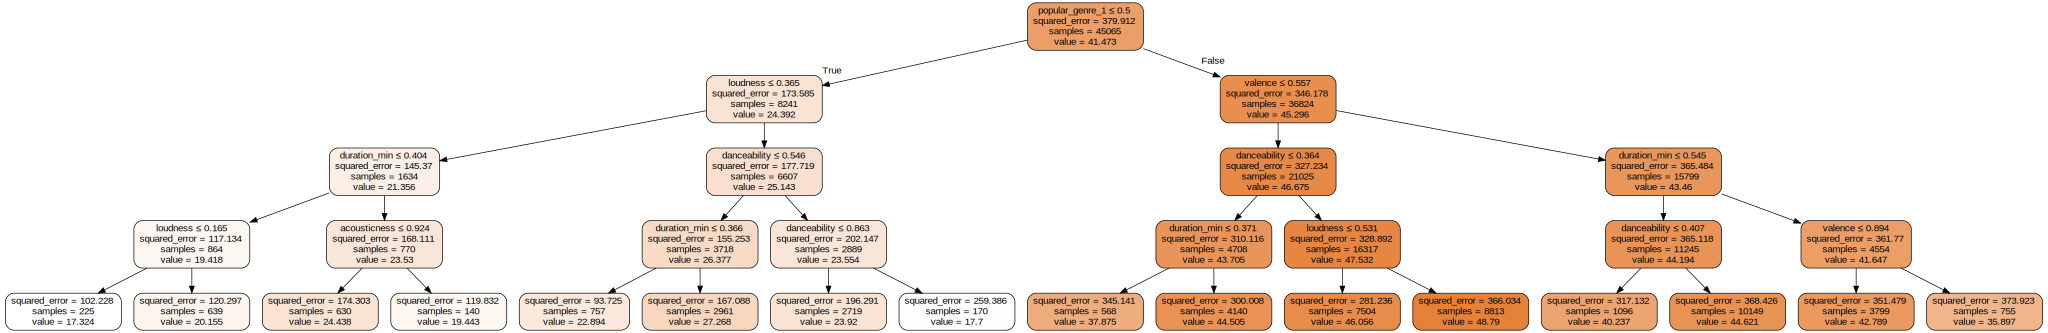

In [101]:
# Your code here
dot_data = export_graphviz(
    reg,
    feature_names=X_reg.columns,
    filled=True,
    rounded=True,
    special_characters=True
)

Source(dot_data)

In [94]:
# Your code here, too!
feat_imp = pd.DataFrame({
    'features': X_reg.columns,
    'importances': reg.feature_importances_
}).sort_values(by='importances', ascending=False)
feat_imp['importances'] = feat_imp['importances'].round(2)

In [95]:
print(feat_imp)

            features  importances
10   popular_genre_1         0.18
8              tempo         0.10
7            valence         0.10
2           loudness         0.10
1       danceability         0.10
4       acousticness         0.09
0       duration_min         0.09
3        speechiness         0.09
6           liveness         0.08
5   instrumentalness         0.06
14            mode_1         0.01
12     explicit_True         0.01
13            mode_0         0.00
11    explicit_False         0.00
15  time_signature_0         0.00
16  time_signature_1         0.00
9    popular_genre_0         0.00


**Discussion Q1. Do the important features make sense within the context of this smoker dataset?**

- Most of the important features make sense in the context of music popularity. For example, popular_genre_1, valence, and danceability are all related to how a song feels emotionally or rhythmically, which aligns with what people tend to enjoy. These are reasonable indicators of why a song might be more popular.

(Your answer here)

**Discussion Q2. Do these importances tell us anything about _causal_ linkages between our predictors and `popularity`? Why or why not?**

- The feature importances show which variables are helpful for prediction, but they don't necessarily indicate a causal relationship. For example, a certain genre may be strongly associated with popularity, but we can't say it directly causes a song to become popular. The model picks up on correlations, not cause-and-effect.

(Your answer here)

**Discussion Q3. How do the visualizations of `best_dt_reg` and `best_dt_clf` differ?**

- The regression tree tends to be deeper and has more splits because it's trying to predict a continuous score. The classification tree has fewer splits since it's just separating data into categories. So the the regressor looks more complex.

(Your answer here)

**Discussion Q4. How does the "score" function differ between decision tree classifiers and regressors more broadly?**

- For decision tree classifiers, the .score() function returns accuracy — the proportion of correct predictions. For regressors, it returns the R² score, which measures how well the model explains the variance in the target variable. So although the function name is the same, the meaning is different depending on the task.

(Your answer here)

# Conclusion

In this assignment, we predict music popularity based on audio features.
- We modeled the relationship between audio features and music popularity with thre tree-based classifiers, attaining a fairly accurate result.
- We utilized the properties of the models to gain a better understanding of which features contributed the most to differentiating popular and non popular songs.
- Interpreting these results within the context of the dataset - along with our prior knowledge of factors related with music popularity - helped us better understand how different audio features impact a song's popularity.
- Comparing the decision tree and random forest classifiers shed light on how each model's pros and cons can impact the robustness of results.

In the later section, we switched our target to a numerical variable `popularity` and build a decision tree regressor to predict music popularity based on audio features. We follow the similar logic to visualize the model and interprete important features to validate model integrity. Specifically, we compared the decision tree classifier and regressor to provide an intuitive understanding of the difference between the two models in terms of node splitting criteria and scroing metrics.